This notebook reuses our original neural network to see how it handles this classification task now that we have utilised a different methodology for preprocessing. 

Sequential neural networks are well-suited for sentiment classification tasks in natural language processing (NLP) due to their ability to handle the sequential nature of text data, accommodate variable-length inputs, and capture dependencies and contextual information. Recurrent Neural Network architectures like LSTMs also maintain a hidden state that remembers past information, allowing them to capture the sentiment of words in relation to their context within a sentence or document. Therefore, it is reasonable to see if a neural net can handle this task.

## Imports and Setup

In [1]:
# Imports and Setup
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import nltk
from string import punctuation
from nltk.corpus import stopwords, words
from nltk.stem import WordNetLemmatizer
from nltk import classify
from sklearn import metrics, preprocessing, feature_extraction, linear_model, naive_bayes, ensemble, pipeline, svm, model_selection, decomposition
from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve, roc_auc_score, classification_report
import warnings
from sklearn.exceptions import UndefinedMetricWarning
warnings.filterwarnings("ignore", category=UndefinedMetricWarning)
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB, GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.multioutput import MultiOutputRegressor, MultiOutputClassifier
from sklearn.datasets import make_classification
from sklearn import tree, datasets
from scipy import stats
from scipy.sparse import csr_matrix
from tensorflow.keras import models, layers, mixed_precision
from tensorflow.keras.layers import Dense, LSTM, Dropout, Embedding, Bidirectional
from tensorflow.keras.metrics import Precision, Recall, CategoricalAccuracy
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics import multilabel_confusion_matrix

# Tell TensorFlow to run all deep learning on GPU:
tf.config.set_soft_device_placement
tf.test.is_built_with_cuda()
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [2]:
# Feature extractor and vectorizer, to produce TF-IDF document matrix:
def feature_vectorizer(corpus):
    sa_stop_words = nltk.corpus.stopwords.words('english')
    ''' Create a list of exceptions, as these stopwords may change a sentence's sentiment if removed. '''
    sa_white_list = ['what', 'but', 'if', 'because', 'as', 'until', 'against', 'up', 'down', 'in', 'out',
                    'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'why',
                    'how', 'all', 'any', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own',
                    'same', 'so', 'than', 'too', 'can', 'will', 'just', 'don', 'should']
    ''' Remove stop words except for those specified in the white list. '''
    sa_stop_words = [sw for sw in sa_stop_words if sw not in sa_white_list]
    ''' Instantiate the vectorizer. '''
    count_vectorizer = feature_extraction.text.CountVectorizer(
        lowercase = True,
        tokenizer = nltk.word_tokenize,
        min_df=2, # this means the term frequency must be 2 or higher.
        ngram_range=(1,2),
        stop_words=sa_stop_words
    )
    ''' Run the vectorizer on the body of text ('corpus'). '''
    processed_corpus = count_vectorizer.fit_transform(corpus)
    processed_corpus = feature_extraction.text.TfidfTransformer().fit_transform(processed_corpus)
    return processed_corpus

def data_integrity_check(df, title='', include_non_numeric=True):
    '''Check for nulls, duplicates, etc and perform basic EDA.'''
    results = []
    for col in df:
        result = {
            'Column': col,
            'Null Values': df[col].isnull().sum(),
            'Duplicate Values': df[col].duplicated().sum(),
            'Data Type': df[col].dtype
        }
        if include_non_numeric or df[col].dtype in ['int64', 'float64']:
            result['Unique Values'] = df[col].nunique()
            if df[col].dtype in ['int64', 'float64']:
                result['Mean'] = df[col].mean()
                result['Median'] = df[col].median()
                result['Mode'] = stats.mode(df[col])
                result['Range'] = df[col].max() - df[col].min()
                result['Skew'] = df[col].skew()
                result['Kurtosis'] = df[col].kurtosis()
        if df[col].dtype == 'object':  
            result['Min Text Length'] = df[col].str.len().min()
            result['Max Text Length'] = df[col].str.len().max()
            '''Calculate mean and median text lengths'''
            text_lengths = df[col].str.len()
            result['Mean Text Length'] = np.mean(text_lengths)
            result['Median Text Length'] = np.median(text_lengths)
        results.append(result)
    result_df = pd.DataFrame(results)
    result_df['Source'] = title
    return result_df

# Prints performance metrics for classifiers:
def print_classification_report(y_true, y_pred):
    '''Get a classification report for performance metric inspection.'''
    report = classification_report(y_true, y_pred)
    print(report)

In [3]:
# Import dataset from preprocessing outputs:
df_sa = pd.read_csv('lsa_train_output.csv')
print(df_sa.shape)

# Reimport training labels:
df_train = pd.read_csv('sa_train.csv')
print(df_train.shape)

# Training data split
X_training = df_sa
y = df_train[df_train.columns[2:]].values

# Classification labels for test data:
df_test_labels = pd.read_csv('sa_test_labels.csv')

# Test data with text only:
df_test_data = pd.read_csv('lsa_test_output.csv')

# Ensure binary nature of test labels:
df_test_labels[df_test_labels == -1] = 1
for col in df_test_labels:
    unique_values = df_test_labels[col].unique()
print(f'Data check: ', unique_values)

(159571, 400)
(159571, 8)
Data check:  [1 0]


Remember, those datasets we just imported have already been cleaned, tokenized, vectorized, and underwent LSA in the preprocessing notebook.

## Sequential Neural Network

In [4]:
# How would our neural network from before fare on this new data?
# I'd like to test it because the preprocessing has changed:

# Create TensorFlow dataset from numpy arrays
dataset = tf.data.Dataset.from_tensor_slices((X_training, y))

# Cache the dataset in memory, shuffle all 160,000 comments.
# Group and store comments in batches of 16.
# Prefetch half batches to prevent processing bottlenecks.
dataset = dataset.cache()
dataset = dataset.shuffle(160000)
dataset = dataset.batch(16)
dataset = dataset.prefetch(8)

# I decided on a train/validate/test split of 70/20/10.
# Use .take() and .skip() to partition the dataset.
train_size = int(0.7 * len(dataset))
validate_size = int(0.3 * len(dataset))

# Split the dataset
train_dataset = dataset.take(train_size)
validate_dataset = dataset.skip(train_size).take(validate_size)

In [5]:
# Restating max tokens as 200,000 from earlier.
max_tokens = 200000

# We want a sequential model with multiple layers.
# Embedding layer needs to match dimension of input data.
# LSTM layer 64 units with tanh activation.
# Bidirectional wrapper since this is a Recurrent Neural Network.
# 3 Dense layers to analyze features with ReLU activation.
# Final dense layer mapped to 6 outputs to match y feature length.
# Sigmoid activation because output is binary/categorical from 0 to 1.
# mask_zero=True stops padding of zero tokens from biasing learning.

# Instantiate model:
SNN_model = tf.keras.Sequential([
    tf.keras.layers.Embedding(max_tokens + 1, 400, mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, activation='tanh')),
    tf.keras.layers.Dense(128, activation="relu"),
    tf.keras.layers.Dense(256, activation="relu"),
    tf.keras.layers.Dense(128, activation="relu"),
    tf.keras.layers.Dense(6, activation='sigmoid')])

# Now we compile to model and set the optimizer.
# BinaryCrossentropy for loss because output is binary classifier.
# Can use Adam or Stochastic Gradient Descent (SGD)  as optimizer.
SNN_model.compile(loss='BinaryCrossentropy', optimizer='Adam')

# Enable mixed precision training to help with memory management:
mixed_precision.set_global_policy('mixed_float16')
# Without the above line, the model runs out of memory and outputs errors.

# View summary:
SNN_model.summary()

INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: NVIDIA RTX 2000 Ada Generation Laptop GPU, compute capability 8.9
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 400)         80000400  
                                                                 
 bidirectional (Bidirectiona  (None, 128)              238080    
 l)                                                              
                                                                 
 dense (Dense)               (None, 128)               16512     
                                                                 
 dense_1 (Dense)             (None, 256)               33024     
                                                             

In [6]:
# Let's start the training process. I set epochs as 2,
# I've tried 1 - 5 and 2 seems to be the sweet spot.
# Use train/test/validate splits that we defined earlier.
trained_model = SNN_model.fit(train_dataset, epochs = 2, validation_data = validate_dataset)

Epoch 1/2
6981/6981 [==============================] - 699s 100ms/step - loss: 0.1436 - val_loss: 0.1451
Epoch 2/2
6981/6981 [==============================] - 690s 99ms/step - loss: 0.1415 - val_loss: 0.1419


In [7]:
# Save the model for convenience:
SNN_model.save("SA_SNN.keras")
# To load: tf.keras.models.load_model('SA_SNN.keras')

<function matplotlib.pyplot.show(close=None, block=None)>

<Figure size 1000x500 with 0 Axes>

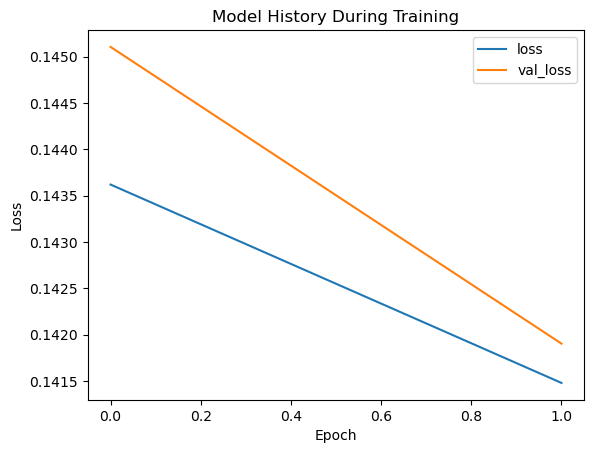

In [8]:
# Let's see training performance history for evaluation purposes.
plt.figure(figsize=(10, 5))
pd.DataFrame(trained_model.history).plot()
plt.title('Model History During Training')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show

In [9]:
# Instantiate new data from df_test:
X_testing = df_test_data
y_true = df_test_labels[df_test_labels.columns[1:]].values

# Create TensorFlow dataset from numpy arrays
test_dataset = tf.data.Dataset.from_tensor_slices((X_testing, y_true))

# Cache the dataset in memory, shuffle all 160,000 comments.
# Group and store comments in batches of 32.
# Prefetch half batches to prevent processing bottlenecks.
test_dataset = test_dataset.cache()
test_dataset = test_dataset.batch(16)
test_dataset = test_dataset.prefetch(8)

# Run model & metrics on entire test dataset now.
y_pred_probs = SNN_model.predict(test_dataset)

# Flatten the true and predicted labels
y_true_flat = []
y_pred_flat = []

for X_true, y_true_batch in test_dataset:
    y_true_flat.extend(y_true_batch.numpy())
    y_pred_batch = SNN_model.predict(X_true, verbose=0)
    y_pred_batch_rounded = (y_pred_batch >= 0.5).astype(int)
    y_pred_flat.extend(y_pred_batch_rounded)

# Convert lists to numpy arrays
y_true_flat = np.array(y_true_flat)
y_pred_flat = np.array(y_pred_flat)

# Print classification report
print(classification_report(y_true_flat, y_pred_flat, target_names=df_test_labels.columns[1:]))

9573/9573 [==============================] - 236s 25ms/step
               precision    recall  f1-score   support

        toxic       0.00      0.00      0.00     95276
 severe_toxic       0.00      0.00      0.00     89553
      obscene       0.00      0.00      0.00     92877
       threat       0.00      0.00      0.00     89397
       insult       0.00      0.00      0.00     92613
identity_hate       0.00      0.00      0.00     89898

    micro avg       0.00      0.00      0.00    549614
    macro avg       0.00      0.00      0.00    549614
 weighted avg       0.00      0.00      0.00    549614
  samples avg       0.00      0.00      0.00    549614



In [10]:
# Let's check out some confusion matrices:
cm_snn = multilabel_confusion_matrix(y_true_flat, y_pred_flat)

# Print classes with matching number for reference:
class_mapping = {
    0: 'Toxic',
    1: 'Severely Toxic',
    2: 'Obscene',
    3: 'Threat',
    4: 'Insult',
    5: 'Identity Hate'
}

# Printing confusion matrices:
print("\nConfusion Matrix for Neural Net Classifier:")
for i, cm in enumerate(cm_snn):
    class_name = class_mapping[i]
    print(f"\nClass {class_name}:\n{cm}")


Confusion Matrix for Neural Net Classifier:

Class Toxic:
[[57888     0]
 [95276     0]]

Class Severely Toxic:
[[63611     0]
 [89553     0]]

Class Obscene:
[[60287     0]
 [92877     0]]

Class Threat:
[[63767     0]
 [89397     0]]

Class Insult:
[[60551     0]
 [92613     0]]

Class Identity Hate:
[[63266     0]
 [89898     0]]


How bizarre, the neural net is only classifying False and True negative classes (0), no true or false positives (1).

This is either an issue with the network, it's training, or the preprocessing I've used with NLTK and LSA.

Or, it might just be that a sequential neural network isn't the best approach to completing this task. People love to rave about the capabilities of neural networks, but they're not always the best option.

To help with interpretation: https://towardsdatascience.com/understanding-the-confusion-matrix-from-scikit-learn-c51d88929c79

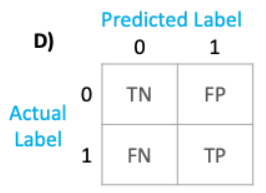